In [742]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from pyclustertend import hopkins
from sklearn.cluster import AgglomerativeClustering
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

In [743]:
def create_cluster(model, max_d):
    # create linkage matrix
    counts = np.zeros(model.children_.shape[0])
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    clusters = fcluster(linkage_matrix, max_d, criterion='distance')
    return clusters


def plotDendrogram(model):
    # create linkage matrix and then plot the dendrogram

    counts = np.zeros(model.children_.shape[0])
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)    
    plt.figure(figsize=(15, 6)) 
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Data Points')
    plt.ylabel('distance')
    dendrogram(linkage_matrix,
                   orientation='top', #The direction to plot the dendrogram
                              #The root at the top, and descendent links going downwards
                   #labels=statesList,
                   distance_sort='descending',
                   show_leaf_counts=True)
    plt.show()

def truncatedDendrogram(model, n, y_min = 0, max_d = 0):
    # truncated dendrogram plot

    counts = np.zeros(model.children_.shape[0])
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)    
    plt.title('Hierarchical Clustering Dendrogram (truncated)')
    plt.xlabel('sample index')
    plt.ylabel('distance')
    dendro = dendrogram(
                    linkage_matrix,
                    truncate_mode='lastp',  # show only the last p merged clusters
                    p=n,  # show only the last p merged clusters
                    leaf_rotation=90.,
                    leaf_font_size=12.,
                    show_contracted=True,  # to get a distribution impression in truncated branches
                )
    for i, d, c in zip(dendro['icoord'], dendro['dcoord'], dendro['color_list']):
        x = 0.5 * sum(i[1:3])
        y = d[1]
        #if y > annotate_above:
        plt.plot(x, y, 'o', c=c)
        plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                            textcoords='offset points',
                            va='top', ha='center')
    if max_d:
            plt.axhline(y=max_d, c='k')

    plt.ylim(ymin = y_min)
    plt.show()

In [744]:
pcaData = pd.read_csv('./Data/PCAData.csv')
pcaData.drop(['Player','Team'],axis=1,inplace=True)
pcaData.describe().round(1)

,PC1,PC2,PC3,PC4,PC5
count,397.0,397.0,397.0,397.0,397.0
mean,-0.0,0.0,0.0,-0.0,0.0
std,5.4,4.7,2.8,2.5,2.1
min,-10.4,-8.2,-7.1,-6.3,-5.7
25%,-4.1,-3.3,-1.9,-1.6,-1.5
50%,-1.2,-1.0,-0.2,-0.0,-0.0
75%,3.3,2.3,1.9,1.6,1.3
max,16.9,16.5,8.1,8.9,9.6


In [745]:
# to standardise the principle components
scaler = StandardScaler()
pcaDataScaled = scaler.fit_transform(pcaData)

In [746]:
# check if components are standardised
pcaDataScaled = pd.DataFrame(pcaDataScaled, columns = ['PC1','PC2','PC3','PC4','PC5'])
pcaDataScaled.describe().round(1)

,PC1,PC2,PC3,PC4,PC5
count,397.0,397.0,397.0,397.0,397.0
mean,-0.0,0.0,-0.0,-0.0,0.0
std,1.0,1.0,1.0,1.0,1.0
min,-1.9,-1.8,-2.5,-2.5,-2.7
25%,-0.8,-0.7,-0.7,-0.6,-0.7
50%,-0.2,-0.2,-0.1,-0.0,-0.0
75%,0.6,0.5,0.7,0.6,0.6
max,3.1,3.5,2.9,3.6,4.5


In [747]:
# conducting hopkins test
hopkins(pcaDataScaled,pcaDataScaled.shape[0])

0.2776856115054058

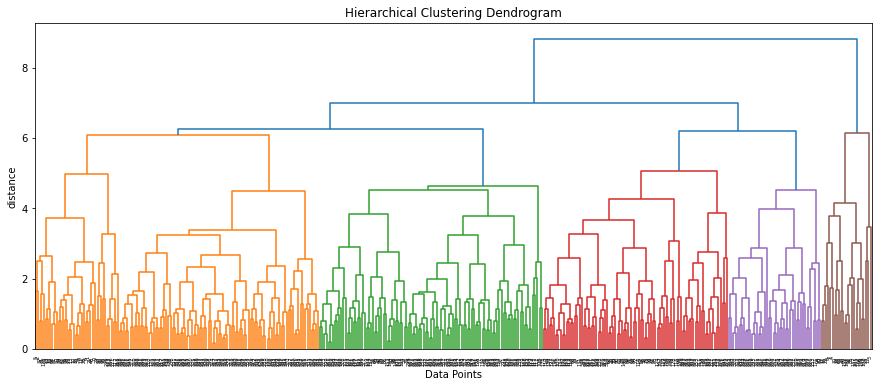

In [748]:
completeLinkage = AgglomerativeClustering(distance_threshold=0, n_clusters=None,linkage='complete')
completeLinknage = completeLinkage.fit(pcaDataScaled)
plotDendrogram(completeLinkage)

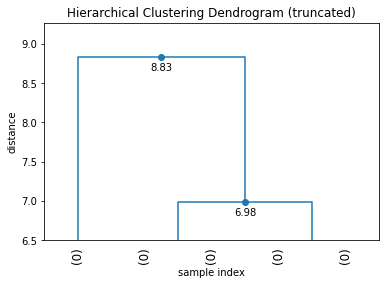

In [749]:
truncatedDendrogram(completeLinkage,5,6.5)

In [750]:
pcaDataScaled['completeCluster'] = create_cluster(completeLinkage,6.5)
pcaDataScaled.groupby('completeCluster').mean()

,PC1,PC2,PC3,PC4,PC5
completeCluster,,,,,
1,1.794286,1.658494,0.084947,0.920019,0.958354
2,0.275816,-0.009909,0.177366,0.154350,-0.799383
3,-0.329754,-0.159734,-0.105606,-0.176160,0.342399


In [751]:
pcaDataScaled['completeCluster'].value_counts()

3    241
2    132
1     24
Name: completeCluster, dtype: int64

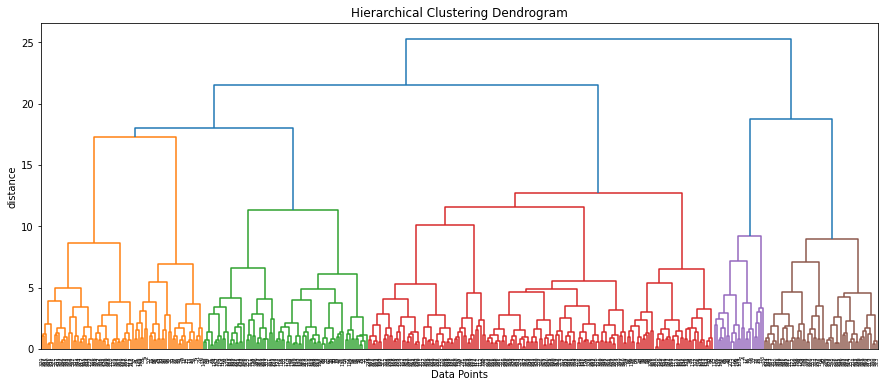

In [752]:
wardLinkage = AgglomerativeClustering(distance_threshold=0, n_clusters=None,linkage='ward')
wardLinkage = wardLinkage.fit(pcaDataScaled)
plotDendrogram(wardLinkage)

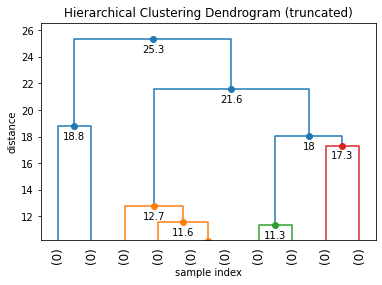

In [753]:
truncatedDendrogram(wardLinkage,10,10.2)

In [754]:
pcaDataScaled['wardCluster'] = create_cluster(wardLinkage,10.2)
pcaDataScaled.groupby('wardCluster').mean()

,PC1,PC2,PC3,PC4,PC5,completeCluster
wardCluster,,,,,,
1,1.374749,-0.492201,0.670865,-0.369166,-0.712699,2
2,1.794286,1.658494,0.084947,0.920019,0.958354,1
3,0.250158,0.009704,-1.143834,-0.943381,-0.076434,3
4,-0.137073,-0.862932,-0.080835,-0.434244,0.722331,3
5,-0.233339,-0.448583,-0.747564,0.720470,0.242417,3
6,-0.565495,0.607674,0.011039,-0.157252,-0.608755,2
7,-0.380791,-0.043142,-0.391181,1.389066,-1.183752,2
8,-0.821388,1.826704,0.401026,-1.026791,0.011560,3
9,-0.917509,-0.369041,1.261179,0.428549,0.529520,3


In [755]:
pcaDataScaled['wardCluster'].value_counts()

4    67
5    56
1    54
6    44
9    44
3    41
7    34
8    33
2    24
Name: wardCluster, dtype: int64

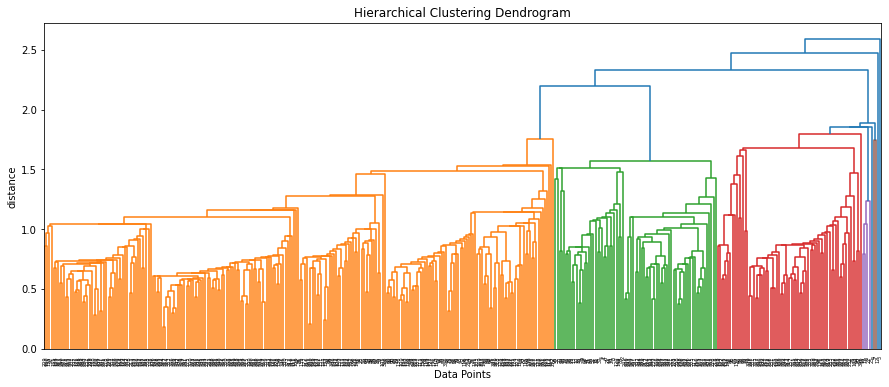

In [756]:
singleLinkage = AgglomerativeClustering(distance_threshold=0, n_clusters=None,linkage='single')
singleLinkage = singleLinkage.fit(pcaDataScaled)
plotDendrogram(singleLinkage)

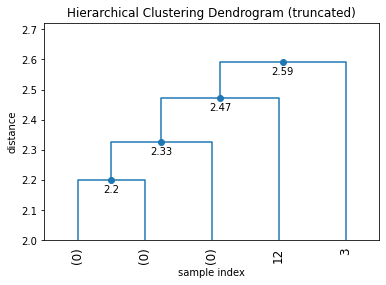

In [757]:
truncatedDendrogram(singleLinkage,5,2)

In [758]:
pcaDataScaled['singleCluster'] = create_cluster(singleLinkage,2)
pcaDataScaled.groupby('singleCluster').mean()

,PC1,PC2,PC3,PC4,PC5,completeCluster,wardCluster
singleCluster,,,,,,,
1,-0.876314,0.571993,0.892542,-0.195168,0.307537,3.000000,8.571429
2,-0.205881,-0.236646,-0.442112,0.053233,-0.033864,2.677686,4.847107
3,1.475965,0.086860,0.514567,-0.040500,-0.291911,1.710526,1.289474
4,2.532788,3.533143,0.364886,3.582430,2.157317,1.000000,2.000000
5,2.593196,3.090430,-1.206564,1.641014,4.542649,1.000000,2.000000


In [759]:
pcaDataScaled['singleCluster'].value_counts()

2    242
1     77
3     76
4      1
5      1
Name: singleCluster, dtype: int64

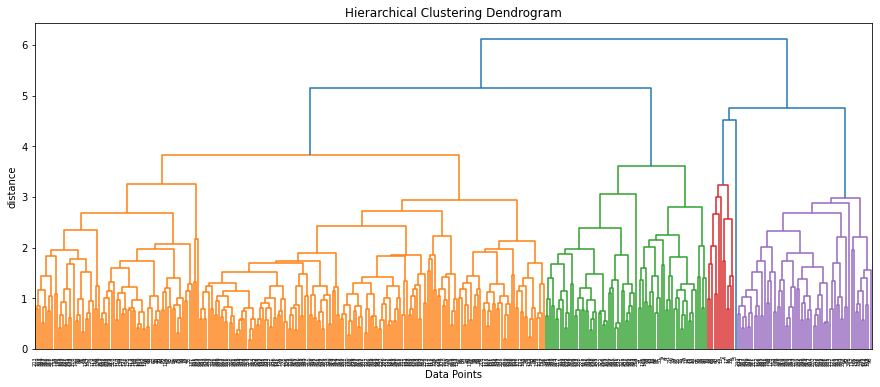

In [760]:
avgLinkage = AgglomerativeClustering(distance_threshold=0, n_clusters=None,linkage='average')
avgLinkage = avgLinkage.fit(pcaDataScaled)
plotDendrogram(avgLinkage)

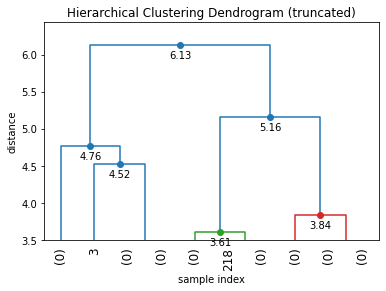

In [761]:
truncatedDendrogram(avgLinkage,10,3.5)

In [762]:
pcaDataScaled['averageCluster'] = create_cluster(avgLinkage,3.5)
pcaDataScaled.groupby('averageCluster').mean()

,PC1,PC2,PC3,PC4,PC5,completeCluster,wardCluster,singleCluster
averageCluster,,,,,,,,
1,1.503377,-0.317305,0.653566,-0.238613,-0.585599,1.84375,1.156250,3.000000
2,1.422306,2.341698,-0.181250,1.213513,1.342339,1.00000,2.000000,3.076923
3,2.593196,3.090430,-1.206564,1.641014,4.542649,1.00000,2.000000,5.000000
4,-0.821388,1.826704,0.401026,-1.026791,0.011560,3.00000,8.000000,1.000000
5,-0.917509,-0.369041,1.261179,0.428549,0.529520,3.00000,9.000000,1.000000
6,-0.073137,-0.503288,-0.574248,-0.167236,0.358767,3.00000,4.091463,2.000000
7,-0.484983,0.323985,-0.164287,0.516784,-0.859395,2.00000,6.435897,2.000000


In [763]:
pcaDataScaled['averageCluster'].value_counts()

6    164
7     78
1     64
5     44
4     33
2     13
3      1
Name: averageCluster, dtype: int64

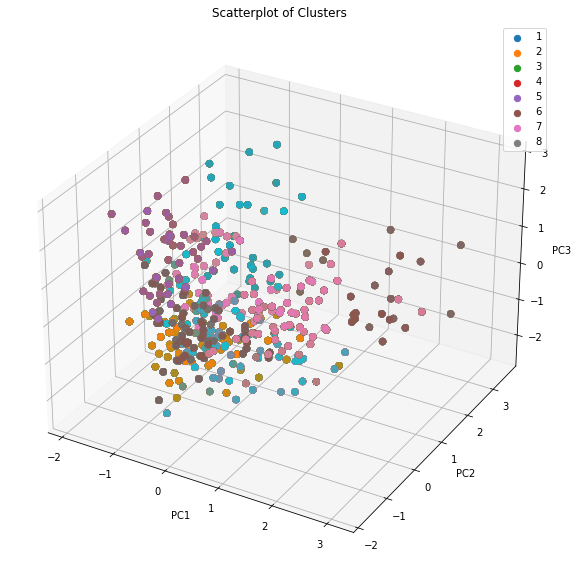

In [764]:

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
for i in pcaDataScaled['wardCluster']:
    x = np.array(pcaDataScaled[pcaDataScaled['wardCluster'] == i]['PC1'])
    y = np.array(pcaDataScaled[pcaDataScaled['wardCluster'] == i]['PC2'])
    z = np.array(pcaDataScaled[pcaDataScaled['wardCluster'] == i]['PC3'])
    ax.scatter(x, y, z, marker = 'o', s = 40)
plt.title('Scatterplot of Clusters')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend([1,2,3,4,5,6,7,8])
plt.show()

In [765]:
fig2 = px.scatter_3d(pcaDataScaled, x='PC1', y='PC2', z='PC3', color='wardCluster')
fig2

In [766]:
pcaDataFull = pd.read_csv('./Data/PCAData.csv')
pcaDataScaled['PLAYER'] = pcaDataFull['Player'].values
pcaDataScaled['TEAM'] = pcaDataFull['Team'].values
pcaDataScaled = pcaDataScaled[['PLAYER','TEAM','wardCluster','PC1','PC2','PC3','PC4','PC5']]
pcaDataScaled.rename({'wardCluster':'CLUSTER'},axis=1,inplace=True)
pcaDataScaled.to_csv('Data/clusteredData.csv', index = False)